# Introduction
This notebook gives suggests how to solve the problem of non-linear compressible flow using the automatic differentiation library included in PorePy. 


# Model
As an example, we will set up a non-linear problem for compressible flow. As usuall, we assume Darcy's law is valid:
$$
\vec u = -\mathcal K \nabla p,
$$
where $\vec u$ is the flux, $\mathcal K$ the permeability tensor and $p$ the fulid pressure. Further, the conservation of mass gives
$$
\frac{\partial \phi \rho}{\partial t} + \nabla \cdot \rho \vec u = q,\quad \text{in}\ \Omega \\
u\cdot n = 0,\quad \text{on}\ \partial \Omega
$$
for porosity $\phi$, fluid density $\rho$, and source/sink term $q$.

To solve this system of equation we need a constitutive law relating the fluid density to the pressure:
$$
\rho = \rho_r e^{c(p - p_r)},
$$
for reference density $\rho_r$ and pressure $p_r$.

## Import statements

In [1]:
import numpy as np
import scipy.sparse as sps
import matplotlib.pyplot as plt

# Porepy modules
import porepy as pp
import porepy.ad as ad

## Define constitutive laws and constants

We set the porosity to 0.2 and let set the permeability to the default value (i.e. $\mathcal K = 1$).
We define the depenecy of $\rho$ on $p$ as a function. Note that we have to use the exponent function ad.exp (and not np.exp)

In [2]:
# Define data
dt = 0.2                           # Time step
phi = 0.2                          # Porosity 
c = 1e-1                           # Compressibility

# Constitutive law
def rho(p):
    rho0 = 1
    p_ref = 1
    return rho0 * ad.exp(c * (p - p_ref))

## Discretization

We use a finite-volume method to discretize the model equation. As a first step we create a partition of the domain into grid cells:



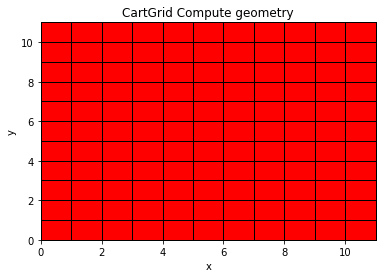

In [3]:
# Create grid
g = pp.CartGrid([11,11])
g.compute_geometry()
pp.plot_grid(g, plot_2d=True)

Next, the model equation is integrated over each controll volume (i.e., each cell of the grid), and the divergence theorem is applied to the flux term:
$$
\int_\Omega \phi \frac{\partial \rho}{\partial t} dV - \int_{\partial\Omega}\vec n\cdot(\rho\vec u)dS - \int_\Omega q dV= 0
$$

The key-point of the finite-volume discretization is how the flux-term $\vec u$ is approximated. We do not cover that in this tutorial(see e.g., I. Aavatsmark. An introduction to multipoint flux approximations for quadrilateral grids. Comput. Geosci., Vol. 6, No. 3, pp. 405–432, 2002. DOI: 10.1023/A:1021291114475).
However, the main idea is that the fluid flux $\vec u$ across a face is expressed as a linear combination of the cell-centered pressures $\vec u = \text{flux}\ \vec p$. Here, $\text{flux}$ is the discretization matrix and $\vec p$ is the vector of all cell-centered pressures.

In porepy we can obtain the discretization matrix with, e.g, the two-point flux approximation:


In [4]:
# Initialize default data (i.e., unit parameters)
data = pp.initialize_default_data(g, {}, 'flow')
# Define flux discretization:
flx_disc = pp.Tpfa('flow')
# Discretize
flx_disc.discretize(g, data)
# The flux discretization can now be found in the dictionary as:
flux = data[pp.DISCRETIZATION_MATRICES]['flow']['flux']

Note that the negative sign in front of the surface-integral is included into the flux discretization matrix.

The density is defined at the cell centers, but in the flux term we need to evaluate it at the faces. To do so, we simply take the average of the two neighbooring cells (note that other alternatives, such as upstream weighting, are commonly used).

We also create discretized versions of the divergence operator div. The discrete divergence operator sums the fluxes in and out of each grid cell.

In [5]:
cell_faces_T = g.cell_faces.T
def div(x):
    """
    Discrete divergence
    """
    return cell_faces_T * x

def avg(x):
    """
    Averageing. Note that this is not strictly correct for the boundary faces since
    these only have 1 cell neighboor, but we have zero flux condition on these, so 
    this is not a problem.
    """
    return 0.5 * np.abs(g.cell_faces) * x

## Residual function
To discretize the time-deriveative, we use backward Euler. Further, we assume that the densities are constant over each cell so we can take them out of the integral:
$$
\int_\Omega \phi \frac{\rho^k - \rho^{k-1}}{\Delta t} dV =\phi \frac{\rho^k - \rho^{k-1}}{\Delta t} \int_\Omega dV = \phi \frac{\rho^k - \rho^{k-1}}{\Delta t}V,
$$
where $V$ is the volume of the cell. The same is also done for the source term.

This gives us the residual
$$
\phi \frac{\rho^k - \rho^{k-1}}{\Delta t} V + \text{div}(\text{avg}(\rho^k)\text{flux } p^k) - q^k V= 0
$$

In [6]:
def f(p, p0):
    # darcy:
    u = flux * p

    # Source:
    src = np.zeros(g.num_cells)
    src[60] = 1

    # Define residual function
    time = phi * (rho(p) - rho(p0)) / dt * g.cell_volumes
    advection = div(avg(rho(p)) * u)
    lhs = time + advection
    rhs = src * g.cell_volumes

    return lhs - rhs

## Initialize Ad variable
To initialize an AD variable create an Ad_array(...) with values equal the initial value and jacobian equal the identity matrix

In [7]:
# Set initial condition
p0 = np.zeros(g.num_cells)
p = ad.Ad_array(p0, sps.diags(np.ones(p0.shape)))

## Time loop
We are now ready to set up the time loop. We will set up a simple Newton iteration to find the zero of the residual function.

Solving time step:  1


/home/rbe051/anaconda3/envs/porepy/lib/python3.6/site-packages/mpl_toolkits/mplot3d/axes3d.py:738: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


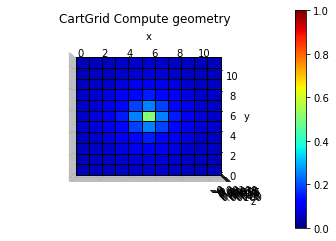

Solving time step:  2


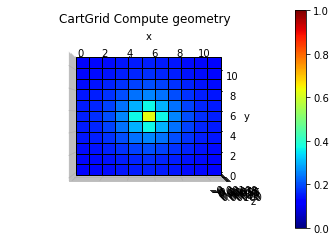

Solving time step:  3


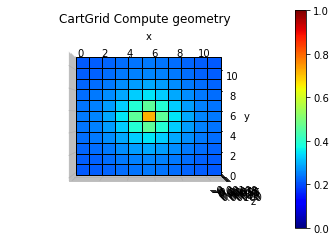

Solving time step:  4


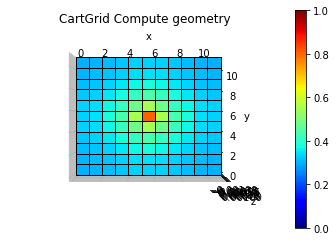

Solving time step:  5


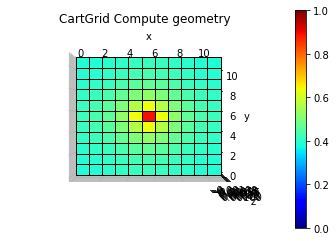

In [8]:
# define iteration parameters
newton_tol = 1e-6
t = .0
T = 1
k = 0
times = [t]

# Time loop
while t < T:
    # Increment time
    t += dt
    k += 1
    times.append(t)
    p0 = p.val
    print('Solving time step: ', k)
    # solve newton iteration
    err = np.inf
    while err > newton_tol:
        eq = f(p, p0)   
        p = p - sps.linalg.spsolve(eq.jac, eq.val)
        err = np.sqrt(np.sum(eq.val**2))
    pp.plot_grid(g, p.val,color_map = [0, 1])